## 特征准备

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import calc_ivs,calc_woe
%matplotlib inline

### plans

In [3]:
def transform_plans(plans):
    #plans dic
    plans_rows = []
    for p_dics in plans['plans'].values:
        plans_rows.extend(p_dics)
    #plans info
    plans['plan_num'] = plans['plans'].apply(len)
    sid_list=[]
    plan_num=[]
    for sid,num in plans[['sid','plan_num']].values:
        sid_list.extend([sid]*num)
        plan_num.extend([num]* num)
    #concat
    df_plan = pd.DataFrame(sid_list,columns=['sid'])
    df_plan['plan_num']=plan_num
    df_plan = pd.concat([df_plan,pd.DataFrame(plans_rows)],axis=1)
    
    df_plan['price'] = df_plan['price'].apply(lambda x:int(x) if x!='' else 0)
    df_plan['speed']= df_plan['distance']*1.0 / df_plan['eta']
    df_plan['time_cost']= df_plan['price']*1.0 / df_plan['eta'] 
    df_plan['plan_order']= df_plan.groupby(['sid']).cumcount()+1
    return df_plan

In [4]:
def gen_plan_rank_feature(df):
    #值排序  
    df_plan = df.copy()
    df_plan['eta_rank'] = df_plan.groupby(['sid'])['eta'].rank(method='first')
    df_plan['distance_rank'] = df_plan.groupby(['sid'])['distance'].rank(method='first')
    df_plan['price_rank'] =  df_plan.groupby('sid')['price'].rank(method='first')
    df_plan['speed_rank'] = df_plan.groupby(['sid'])['speed'].rank(method='first')
    df_plan['time_cost_rank'] = df_plan.groupby(['sid'])['time_cost'].rank(method='first')
    rank_feature = ['eta_rank','distance_rank','price_rank','speed_rank','time_cost_rank']
    return df_plan,rank_feature

In [35]:
def feature_describe(df, by_key, on_col, cols=[]):
    tmp_df = df.groupby(by_key)[on_col].agg(cols)
    tmp_df.columns = [by_key+'_'+on_col+'_'+col for col in cols]   
    df = df.merge(tmp_df.reset_index(),how='left',on=by_key)
    return df
def gen_plan_statis_feature(df): 
    #值统计特征
    df_plan = df.copy()
    feature_org = set(df_plan.columns)
    df_plan = feature_describe(df_plan,'sid','distance',['mean','std','min','max'])
    df_plan = feature_describe(df_plan,'sid','eta',['mean','std','min','max'])    
    df_plan = feature_describe(df_plan,'sid','price',['mean','std','min','max'])  
    df_plan = feature_describe(df_plan,'sid','speed',['mean','std','min','max'])  
    df_plan = feature_describe(df_plan,'transport_mode','distance',['mean', 'std', 'min', 'median', 'max'])
    df_plan = feature_describe(df_plan,'transport_mode','eta',['mean', 'std', 'min', 'median', 'max'])
    df_plan = feature_describe(df_plan,'transport_mode','price',['mean', 'std', 'min','median', 'max'])
    df_plan = feature_describe(df_plan,'transport_mode','speed',['mean', 'std', 'min', 'median', 'max'])
    statis_feature = set(df_plan.columns) - feature_org
    return df_plan,list(statis_feature)    

In [36]:
def gen_plan_feature():
    plans_train = pd.read_csv("data/train_plans.csv", parse_dates=['plan_time'])
    plans_test = pd.read_csv('data/test_plans.csv', parse_dates=['plan_time'])
    plans = pd.concat([plans_train,plans_test],axis=0)
    plans['plans'] = plans['plans'].apply(eval)
    #extract plan features
    df_plan = transform_plans(plans)
    plan_feature = [col for col in df_plan.columns if col!='sid']
    
    #extract rank feature
    df_plan,rank_feature = gen_plan_rank_feature(df_plan)
    
    #extract statis_feature
    df_plan,statis_feature = gen_plan_statis_feature(df_plan)
    
    #extract time features
    time_feature = []
    plans['plan_day'] = plans['plan_time'].apply(lambda x :x.day)
    plans['plan_hour'] = plans['plan_time'].apply(lambda x :x.hour)
    plans['plan_weekday'] = plans['plan_time'].apply(lambda x :x.dayofweek+1)
    time_feature.extend(['plan_day','plan_hour','plan_weekday'])
    
    #merge
    df_plan=df_plan.merge(plans[['sid','plan_time','plan_day','plan_hour','plan_weekday']],how='left',on='sid')
    return df_plan,plan_feature,rank_feature,statis_feature,time_feature

In [41]:
df_plan = gen_plan_feature()
df_plan[0].to_csv('outdata/plans_detail.csv',index=None)
df_plan[0].head(2).T

AttributeError: 'tuple' object has no attribute 'head'

### query

In [57]:
def get_haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [7]:
def gen_query_feature():
    #query data
    train_query = pd.read_csv("data/train_queries.csv", usecols =['sid','pid','o','d'])
    test_query = pd.read_csv("data/test_queries.csv", usecols =['sid','pid','o','d'])
    query = pd.concat([train_query,test_query],axis=0)

    #split o,d
    o_split = query['o'].apply(lambda x:[float(x) for x in x.split(',')])
    d_split = query['d'].apply(lambda x:[float(x) for x in x.split(',')])
    query['o_x'] = o_split.apply(lambda x:x[0])
    query['o_y'] = o_split.apply(lambda x:x[1])
    query['d_x'] = d_split.apply(lambda x:x[0])
    query['d_y'] = d_split.apply(lambda x:x[1])
    query['ED'] = query.apply(lambda x: get_haversine_np(x['']),axis=1)
    query['line_distance'] = query.apply(lambda cols:getDistance(x['o_y'],
                                                        x['o_x'],
                                                        x['d_y'],
                                                        x['d_x']),axis=1)*1000
    query_feature = ['o_x','o_y','d_x','d_y','ED']
    return train_query,test_query,query,query_feature

In [ ]:
def gen_OD_feature(df):
    
    

### user_profile

In [2]:
def gen_profile_feature():
    user = pd.read_csv("data/profiles.csv")
    user['p_sum'] = user.iloc[:,1:].apply(lambda x:x.sum(),axis=1)
    return user

In [47]:
def gen_pid_statis(data):
    feature_org = set(data.columns)
    data = feature_describe(data,'pid','distance',['mean', 'std', 'min','median', 'max'])
    data = feature_describe(data,'pid','eta',['mean', 'std', 'min', 'median', 'max'])
    data = feature_describe(data,'pid','price',['mean', 'std', 'min', 'median', 'max'])
    data = feature_describe(data,'pid','speed',['mean', 'std', 'min', 'median', 'max'])
    sts_feature = user_feature.extend(list(set(data.columns) - feature_org))
    return data,sts_feature

### 模型数据_二分类

In [43]:
def gen_features():
    train_query,test_query,query,query_feature = gen_query_feature()
    df_plan,plan_feature,rank_feature,statis_feature,time_feature = gen_plan_feature()
    user = gen_profile_feature()
    user_feature = list(user.columns[1:])
    
    data = query.merge(df_plan, how='left', on='sid')
    
    #extract personal statistical feature
    data,sts_feature = gen_pid_statis(data)
    statis_feature = statis_feature + sts_feature   
    
    #merge
    data = data.merge(user, how='left', on='pid')
    return (data,query_feature,plan_feature,rank_feature,statis_feature,time_feature,user_feature)

In [44]:
def gen_binary_samples():
    datas =  gen_features()
    data = datas[0]
    
    #train_data
    train_query = pd.read_csv("data/train_queries.csv", usecols =['sid'])    
    click = pd.read_csv("data/train_clicks.csv", usecols =['sid','click_mode'])    
    train = train_query.merge(data, how='left', on='sid')
    train = train.merge(click, how='left', on='sid')
    #add binary label: 第一个与click_mode匹配的transport_mode
    indexs = train[train['transport_mode']==train['click_mode']].groupby(['sid']).head(1).index
    train.loc[indexs,'label']=1
    train['label'].fillna(0,inplace =True)
    train.to_csv('outdata/train.csv',index=None)
    
    #test data
    test_query = pd.read_csv("data/test_queries.csv", usecols =['sid'])
    test = test_query.merge(data, how='left', on='sid')
    test = test[test['plan_time'].notnull()]   #无plans的测试数据，不做预测
    test = test.reset_index(drop=True)
    test.to_csv('outdata/test.csv',index=None)
    return train,test,

In [45]:
train,test  = gen_binary_samples()

In [46]:
train.columns


Index(['sid', 'pid', 'o', 'd', 'o_x', 'o_y', 'd_x', 'd_y', 'ED', 'plan_num',
       ...
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p_sum', 'click_mode',
       'label'],
      dtype='object', length=151)

### embeding

In [ ]:
from gensim.models import word2vec

In [53]:
train.groupby(by=['o'])['transport_mode'].value_counts().unstack().reset_index().fillna(0)

transport_mode,o,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0,"115.47,39.78",2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"115.49,39.98",0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,"115.50,40.03",1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"115.50,40.04",1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,"115.51,39.93",0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,"115.56,40.00",0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,"115.57,39.99",2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,"115.58,39.78",1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,"115.59,39.63",1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
9,"115.59,39.64",1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [51]:
.unstack().reset_index().fillna(0)
train.groupby(by=['d'])['transport_mode'].value_counts().unstack().reset_index().fillna(0)

ValueError: cannot insert transport_mode, already exists

In [ ]:
tmp = train.groupby(by=['o_x','o_y'])['transport_mode'].value_counts().unstack().fillna(0).apply(lambda x:list(x),axis=1).reset_index()
train = train.merge(tmp.rename(columns={0:'mode_counts'}),how='left',on=['o_x','o_y'])
train.head(2)

In [19]:
plans_train = pd.read_csv("data/train_plans.csv", parse_dates=['plan_time'])
plans_test = pd.read_csv('data/test_plans.csv', parse_dates=['plan_time'])
plans = pd.concat([plans_train,plans_test],axis=0)
plans['plans'] = plans['plans'].apply(eval)
#extract plan features
df_plan = transform_plans(plans)
plan_feature = [col for col in df_plan.columns if col!='sid']

#extract rank feature
df_plan,rank_feature = gen_plan_rank_feature(df_plan)

In [37]:
#extract statis_feature
df_statis,statis_feature = gen_plan_statis_feature(df_plan)

In [30]:
df_plan.groupby('transport_mode')['distance'].agg(['mean', 'std', 'min', '25%', '50%', '75%', 'max'])

AttributeError: 'SeriesGroupBy' object has no attribute '25%'

In [38]:
df_statis

,sid,plan_num,distance,eta,price,transport_mode,speed,time_cost,plan_order,eta_rank,...,transport_mode_price_mean,transport_mode_price_std,transport_mode_price_min,transport_mode_price_median,transport_mode_price_max,transport_mode_speed_mean,transport_mode_speed_std,transport_mode_speed_min,transport_mode_speed_median,transport_mode_speed_max
0,1709112,5,32303,5087,600,9,6.350108,0.117948,1,3.0,...,519.449936,316.745063,0,500,3300,5.560091,1.395040,1.913318,5.440238,11.216625
1,1709112,5,33678,3149,0,3,10.694824,0.000000,2,1.0,...,0.000000,0.000000,0,0,0,7.456733,3.439824,0.004854,6.948261,342.000000
2,1709112,5,33678,3269,10000,4,10.302233,3.059039,3,2.0,...,5784.363310,4760.348043,800,4400,92300,6.962369,3.150810,0.002632,6.504455,26.418230
3,1709112,5,32099,5996,600,2,5.353402,0.100067,4,4.0,...,542.040110,476.140282,0,500,3400,5.145197,1.866231,1.202860,5.033312,14.369671
4,1709112,5,30446,6494,900,1,4.688328,0.138589,5,5.0,...,500.984817,567.392725,0,300,15000,3.024856,1.585209,0.417929,2.720400,19.984283
5,3327773,5,3427,627,300,2,5.465710,0.478469,1,2.0,...,542.040110,476.140282,0,500,3400,5.145197,1.866231,1.202860,5.033312,14.369671
6,3327773,5,3251,573,0,3,5.673647,0.000000,2,1.0,...,0.000000,0.000000,0,0,0,7.456733,3.439824,0.004854,6.948261,342.000000
7,3327773,5,3251,693,1600,4,4.691198,2.308802,3,3.0,...,5784.363310,4760.348043,800,4400,92300,6.962369,3.150810,0.002632,6.504455,26.418230
8,3327773,5,3227,977,0,6,3.302968,0.000000,4,4.0,...,0.000000,0.000000,0,0,0,3.320299,0.113828,1.000000,3.312303,9.000000
9,3327773,5,3227,2936,0,5,1.099114,0.000000,5,5.0,...,0.000000,0.000000,0,0,0,1.123821,0.047099,0.362069,1.121212,2.000000


### 模型数据_多分类

In [49]:
def plan_unstack(train,df_new):
    col_plan = ['sid','plan_order','distance', 'eta', 'price', 'transport_mode',  'speed',
       'transport_mode_distance_mean', 'transport_mode_distance_std',
       'transport_mode_distance_min', 'transport_mode_distance_25%',
       'transport_mode_distance_50%', 'transport_mode_distance_75%',
       'transport_mode_distance_max', 'transport_mode_eta_mean',
       'transport_mode_eta_std', 'transport_mode_eta_min',
       'transport_mode_eta_25%', 'transport_mode_eta_50%',
       'transport_mode_eta_75%', 'transport_mode_eta_max',
       'transport_mode_price_unique', 'transport_mode_price_top',
       'transport_mode_price_freq', 'transport_mode_speed_mean',
       'transport_mode_speed_std', 'transport_mode_speed_min',
       'transport_mode_speed_25%', 'transport_mode_speed_50%',
       'transport_mode_speed_75%', 'transport_mode_speed_max',
       'price_freq_ratio', 'transport_mode_price_mean',
       'transport_mode_price_std', 'transport_mode_price_min',
       'transport_mode_price_25%', 'transport_mode_price_50%',
       'transport_mode_price_75%', 'transport_mode_price_max', 'eta_rank',
       'distance_rank', 'price_rank', 'speed_rank', 'eta_model_rank',
       'distance_model_rank', 'speed_model_rank','click_ratio']
    for i in range(1,int(train['plan_num'].max())+1):
        col_plan_new = [x+'_'+str(i) for x in col_plan[1:]]
        tmp = train[train['plan_order']==i][col_plan]
        tmp.columns = ['sid'] + col_plan_new
        df_new = df_new.merge(tmp,how='left',on='sid')
    return df_new

In [50]:
#train_data
train_mult = train_query[['sid','pid']].merge(query[['sid','o_x','o_y','d_x','d_y','ED']],how='left',on='sid')
train_mult = train_mult.merge(plans[['sid', 'plan_day', 'plan_hour', 'plan_weekday', 'plan_num']],how='left',on='sid')
train_mult = plan_unstack(train,train_mult)
train_mult.shape,train_mult.dtypes

((500000, 333), sid                                 int64
 pid                               float64
 o_x                               float64
 o_y                               float64
 d_x                               float64
 d_y                               float64
 ED                                float64
 plan_day                          float64
 plan_hour                         float64
 plan_weekday                      float64
 plan_num                          float64
 plan_order_1                      float64
 distance_1                        float64
 eta_1                             float64
 price_1                           float64
 transport_mode_1                  float64
 speed_1                           float64
 transport_mode_distance_mean_1    float64
 transport_mode_distance_std_1     float64
 transport_mode_distance_min_1     float64
 transport_mode_distance_25%_1     float64
 transport_mode_distance_50%_1     float64
 transport_mode_distance_75%_1     floa

In [51]:
train_mult = train_mult[train_mult['plan_order_1'].notnull()]
train_mult = train_mult.merge(user,how='left',on='pid')
train_mult = train_mult.merge(click[['sid','click_mode']],how='left',on='sid')
train_mult = train_mult.rename(columns={'click_mode':'label'})
train_mult.shape,train_mult.head(2)

((491054, 401),
        sid       pid     o_x    o_y     d_x    d_y      ED  plan_day  \
 0  3000821       NaN  116.29  39.97  116.32  39.96  0.0010       2.0   
 1  3085857  210736.0  116.39  39.84  116.33  39.79  0.0061      16.0   
 
    plan_hour  plan_weekday  ...  p58  p59  p60  p61  p62  p63  p64  p65  \
 0       17.0           5.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
 1       10.0           5.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
 
    p_sum  label  
 0    NaN    9.0  
 1    9.0    1.0  
 
 [2 rows x 401 columns])

In [52]:
train_mult.to_csv('outdata/train_mult.csv',index=None)

In [53]:
#test data
test_mult = test_query[['sid','pid']].merge(query[['sid','o_x','o_y','d_x','d_y','ED']],how='left',on='sid')
test_mult = test_mult.merge(plans[['sid', 'plan_day', 'plan_hour', 'plan_weekday', 'plan_num']],how='left',on='sid')
test_mult = plan_unstack(test,test_mult)
test_mult = test_mult[test_mult['plan_order_1'].notnull()]
test_mult = test_mult.merge(user,how='left',on='pid')
test_mult.shape,test_mult.head(2)

((92571, 400),
        sid       pid     o_x    o_y     d_x    d_y      ED  plan_day  \
 0  1126541  178395.0  116.41  39.92  116.46  39.95  0.0034       5.0   
 1   453685  179178.0  116.39  39.90  116.41  39.91  0.0005       1.0   
 
    plan_hour  plan_weekday  ...  p57  p58  p59  p60  p61  p62  p63  p64  p65  \
 0       14.0           3.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
 1       12.0           6.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
 
    p_sum  
 0   10.0  
 1    8.0  
 
 [2 rows x 400 columns])

In [54]:
test_mult.to_csv('outdata/test_mult.csv',index=None)

In [72]:
click['click_mode'].value_counts()

2     136491
7      78209
1      70369
9      48864
5      47480
3      24626
10     14882
4      12606
6      11863
11      6089
8       1857
Name: click_mode, dtype: int64

### 数据探索性分析

In [57]:
tmp = test[test['plan_order']==1]['transport_mode'].value_counts()*1.0/test[test['plan_order']==1].shape[0]
tmp.values

array([3.56742392e-01, 2.23180046e-01, 1.77236932e-01, 1.12216569e-01,
       5.31483942e-02, 3.51730023e-02, 3.21699020e-02, 5.48767973e-03,
       4.20217995e-03, 4.21298247e-04, 2.16050383e-05])

In [25]:
#特征唯一性分析
cols =['sid','pid','o_x','o_y','d_x','d_y','distance']
for col in cols:
    print(len(train[col].unique()))
train.isnull().sum()
train.nunique()

491054
45247
176
135
185
132
84529


sid                              491054
pid                               45246
o_x                                 176
o_y                                 135
d_x                                 185
d_y                                 132
ED                                 9280
plan_day                             31
plan_hour                            24
plan_weekday                          7
plan_num                              7
distance                          84529
eta                               15746
price                               541
transport_mode                       11
plan_order                            7
speed                           1867422
transport_mode_distance_mean         11
transport_mode_distance_std          11
transport_mode_distance_min           8
transport_mode_distance_25%          11
transport_mode_distance_50%          11
transport_mode_distance_75%          11
transport_mode_distance_max           9
transport_mode_eta_mean              11


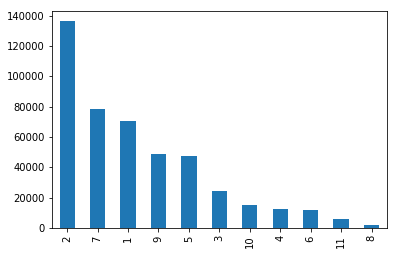

In [26]:
#标签分布统计
click['click_mode'].value_counts().plot(kind='bar')

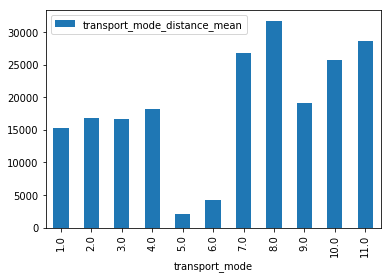

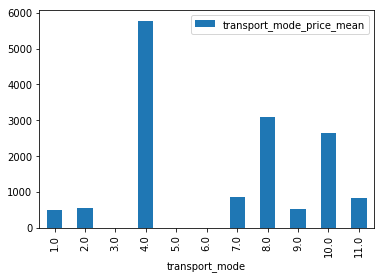

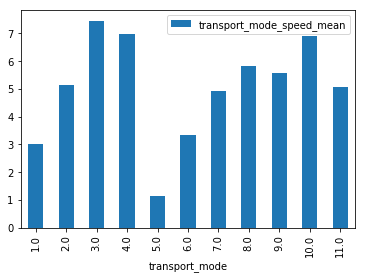

In [30]:
#出行方式的距离，价格，速度分析
tmp = train[['transport_mode','transport_mode_distance_mean']].drop_duplicates().sort_values(['transport_mode'])
tmp.plot(kind='bar',x='transport_mode',y='transport_mode_distance_mean')
tmp = train[['transport_mode','transport_mode_price_mean']].drop_duplicates().sort_values(['transport_mode'])
tmp.plot(kind='bar',x='transport_mode',y='transport_mode_price_mean')
tmp = train[['transport_mode','transport_mode_speed_mean']].drop_duplicates().sort_values(['transport_mode'])
tmp.plot(kind='bar',x='transport_mode',y='transport_mode_speed_mean')

In [35]:
#出发地，目的地对应出行方式分析
tmp = train[train['label']==1][['o_x','o_y','d_x','d_y','transport_mode','distance','eta','price','speed']]
tmp['o'] = tmp[['o_x','o_y']].apply(lambda x:str(x['o_x'])+str(x['o_y']),axis=1)
tmp['d'] = tmp[['d_x','d_y']].apply(lambda x:str(x['d_x'])+str(x['d_y']),axis=1)
tmp['o'].value_counts()

116.4139.91    5219
116.3739.86    5124
116.3239.89    5085
116.4239.9     5069
116.3739.91    4940
116.439.91     4803
116.3939.9     4076
116.3539.94    3463
116.3939.91    2829
116.4139.9     2811
116.3139.98    2791
116.3939.89    2763
116.3939.94    2655
116.439.93     2504
116.4339.94    2463
116.3139.89    2408
116.4739.91    2372
116.4139.92    2358
116.3939.92    2308
116.4539.91    2250
116.3339.99    2247
116.4539.93    2236
116.340.05     2117
116.4539.92    2053
116.3539.91    1921
116.3239.9     1892
116.3739.95    1857
116.4239.84    1784
116.4339.92    1732
116.3940.0     1722
               ... 
116.0339.61       1
116.4640.15       1
116.2539.72       1
116.5240.28       1
115.9439.75       1
115.9440.52       1
116.3340.16       1
116.6640.65       1
115.8340.05       1
117.0740.28       1
116.9540.15       1
116.7839.76       1
116.6739.81       1
115.8939.82       1
116.5240.2        1
116.4440.45       1
115.9339.81       1
116.6940.38       1
116.0940.24       1


In [36]:
tmp['d'].value_counts()

116.3239.89    15232
116.3739.86    11594
116.4239.9     10434
116.3939.9      7036
116.3939.91     6913
116.4139.91     5850
116.3739.91     5172
116.4539.93     4966
116.2740.0      3950
116.439.93      3535
116.3939.92     3432
116.3139.98     3167
116.1839.99     3147
116.040.35      3114
116.439.91      2896
116.3939.99     2737
116.3839.94     2648
116.5940.08     2564
116.3939.89     2496
116.4139.9      2456
116.3339.99     2349
116.4939.98     2319
116.3339.94     2302
116.4539.91     2249
116.640.08      2239
116.4339.94     2171
116.4739.91     2165
116.4539.92     2091
116.3939.94     2079
116.3539.94     1915
               ...  
116.5140.24        1
116.6340.08        1
116.0340.06        1
115.740.05         1
116.8840.47        1
116.2340.02        1
117.2740.17        1
116.8239.69        1
116.039.6          1
117.3140.19        1
116.7239.66        1
115.9340.36        1
116.1439.97        1
116.2240.49        1
116.3440.13        1
116.1439.88        1
115.7239.84  

In [46]:
tmp[tmp['o']=='116.3739.86']['speed'].value_counts()

500.0      1210
400.0      1121
600.0       562
700.0       508
0.0         471
300.0       353
800.0       184
200.0       103
900.0        98
3000.0       82
1800.0       39
1000.0       32
1100.0       25
2000.0       22
1700.0       21
1300.0       20
1200.0       20
2200.0       19
2100.0       16
1900.0       15
2600.0       11
2800.0       11
1400.0       10
2400.0        9
3600.0        8
2300.0        8
2700.0        8
3700.0        8
3400.0        7
3500.0        6
           ... 
6600.0        2
10500.0       1
5400.0        1
7300.0        1
7000.0        1
13600.0       1
8600.0        1
24600.0       1
13200.0       1
6900.0        1
19400.0       1
7200.0        1
8200.0        1
7900.0        1
6400.0        1
12400.0       1
5900.0        1
12700.0       1
6300.0        1
9800.0        1
4000.0        1
6700.0        1
5800.0        1
7600.0        1
9300.0        1
43300.0       1
8100.0        1
14800.0       1
8900.0        1
11100.0       1
Name: price, Length: 87,

In [ ]:
#plan order 
train[train['label']==1]['plan_order'].value_counts().sort_index().plot(kind='bar')
train[train['label']==1]['plan_order'].value_counts()/train[train['label']==1].shape[0]*1.0

In [ ]:
#iv值
ivs = calc_ivs(train)
# pd.DataFrame.from_dict([ivs]).T
pd.DataFrame.from_dict([ivs]).T.sort_values(0,ascending=False)
#woe
woe_df = calc_woe(train,'plan_order')
woe_df

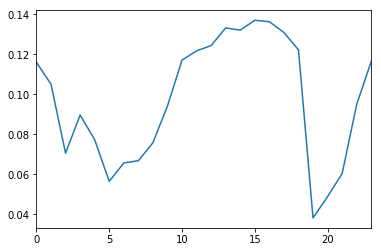

In [47]:
#不同时刻选择某种交通方式的概率
tmp_label =train[train['label']==1]
tmp = tmp_label[tmp_label['transport_mode']==9]['plan_hour'].value_counts().sort_index()*1.0 / tmp_label['plan_hour'].value_counts().sort_index()
tmp.plot()

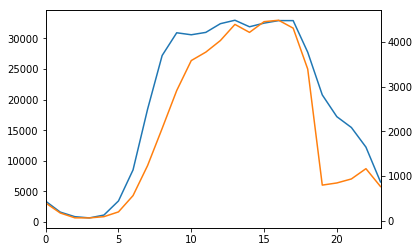

In [46]:
tmp_label['plan_hour'].value_counts().sort_index().plot()
tmp_label[tmp_label['transport_mode']==9]['plan_hour'].value_counts().sort_index().plot(secondary_y=True)

In [450]:
[float(x) for x in train['o'].iloc[0].split(',')]

[116.29, 39.97]

In [324]:
train['price'].value_counts()

         814355
500      167512
200      151633
400      148350
600      111474
700       96135
300       77730
800       49488
1300      48557
900       34252
1800      24406
1700      20821
1000      17529
1900      16280
2000      14246
3000      12542
2900      11565
2100      11433
1100      11360
1500      11294
2200      11240
1400      10962
3200      10514
2700      10449
2500      10442
1600      10240
3100      10176
2300      10098
2800       9904
2400       9486
          ...  
37500         1
39700         1
41600         1
43100         1
43800         1
44500         1
46200         1
46800         1
47500         1
47600         1
47900         1
48000         1
48300         1
48700         1
48800         1
48900         1
49900         1
50100         1
50200         1
50300         1
50600         1
50800         1
51000         1
51100         1
51200         1
51300         1
51600         1
52300         1
52500         1
92300         1
Name: price, Length: 541

In [347]:
train.groupby(['sid'])['eta'].rank(method='first')

0          4.0
1          1.0
2          2.0
3          3.0
4          5.0
5          6.0
6          4.0
7          1.0
8          2.0
9          3.0
10         5.0
11         4.0
12         1.0
13         2.0
14         3.0
15         5.0
16         6.0
17         7.0
18         3.0
19         1.0
20         2.0
21         4.0
22         5.0
23         3.0
24         1.0
25         2.0
26         4.0
27         1.0
28         2.0
29         3.0
          ... 
2285737    1.0
2285738    2.0
2285739    3.0
2285740    5.0
2285741    3.0
2285742    1.0
2285743    2.0
2285744    4.0
2285745    5.0
2285746    1.0
2285747    2.0
2285748    3.0
2285749    4.0
2285750    6.0
2285751    3.0
2285752    1.0
2285753    2.0
2285754    4.0
2285755    5.0
2285756    6.0
2285758    1.0
2285759    1.0
2285760    2.0
2285761    3.0
2285762    4.0
2285763    2.0
2285764    1.0
2285765    3.0
2285766    4.0
2285767    5.0
Name: eta, Length: 2276822, dtype: float64

In [320]:
train.groupby(['transport_mode'])['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
transport_mode,,,,,,,,
1.0,331795.0,15435.580319,17215.573531,353.0,4135.00,9740.0,19994.00,225106.0
2.0,207019.0,16848.614572,11574.214711,859.0,8243.00,14177.0,22648.00,92247.0
3.0,477118.0,16741.178507,15917.537551,1.0,5113.00,12760.0,23453.00,222045.0
4.0,433568.0,18197.494937,15771.703702,1.0,6984.00,14318.0,24718.00,222045.0
5.0,132812.0,2064.065220,1475.367240,1.0,751.00,1783.0,3294.00,5000.0
6.0,196602.0,4209.708462,3001.450461,1.0,1397.00,3813.0,6787.75,10000.0
7.0,237309.0,26900.203309,18386.235293,1754.0,13903.00,22574.0,34707.00,225864.0
8.0,12330.0,31748.252879,22488.094924,6135.0,16369.25,24306.5,39908.75,182949.0
9.0,135523.0,19149.596954,10886.420626,2294.0,11196.00,16721.0,24484.00,90860.0


In [279]:
train[train['label']==1].groupby(['transport_mode'])['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
transport_mode,,,,,,,,
1.0,70369.0,14607.217937,17326.042853,412.0,4190.0,8197.0,17452.00,202734.0
2.0,136491.0,16647.638958,11396.711267,859.0,8225.0,13941.0,22286.00,92247.0
3.0,24626.0,21041.071104,21334.267254,1.0,6325.0,15057.5,28374.00,195277.0
4.0,12606.0,15957.958908,15933.923459,1.0,5117.0,10976.5,21356.75,191676.0
5.0,47480.0,761.401474,647.062245,1.0,318.0,634.0,1001.00,4998.0
6.0,11863.0,2881.374020,2199.210425,1.0,1335.0,2162.0,3836.00,9998.0
7.0,78209.0,29675.256850,20071.199159,1852.0,15112.0,25062.0,38542.00,205188.0
8.0,1857.0,37099.593430,29376.282712,6558.0,17042.0,26774.0,49110.00,182949.0
9.0,48864.0,19339.849726,11093.475413,2552.0,11151.0,16830.0,24952.75,88262.0


In [262]:
train.groupby(['transport_mode'])['eta'].describe()
train[train['label']==1].groupby(['transport_mode'])['eta'].describe()

,count,mean,std,min,25%,50%,75%,max
transport_mode,,,,,,,,
1.0,331795.0,4129.286050,2599.863092,445.0,2128.00,3523.0,5512.0,72992.0
2.0,207019.0,3037.887353,1336.119840,270.0,2053.00,2841.0,3813.0,11083.0
3.0,477118.0,2001.056217,1397.636325,1.0,927.00,1809.0,2812.0,14529.0
4.0,433568.0,2352.325474,1346.560189,1.0,1355.00,2149.0,3112.0,14769.0
5.0,132812.0,1849.051426,1327.443526,1.0,666.00,1595.0,2956.0,4708.0
6.0,196602.0,1271.369793,907.789885,1.0,421.00,1151.0,2051.0,3027.0
7.0,237309.0,5039.303583,2172.225372,1060.0,3493.00,4598.0,6087.0,72638.0
8.0,12330.0,5090.998216,1758.704656,1626.0,3786.25,4730.0,6033.0,15726.0
9.0,135523.0,3254.797031,1191.126475,785.0,2388.00,3076.0,3932.0,10432.0


In [263]:
train.groupby(['transport_mode'])['price'].describe()
train[train['label']==1].groupby(['transport_mode'])['price'].describe()

,count,unique,top,freq
transport_mode,,,,
1.0,331795,77,200,151633
2.0,207019,16,500,60513
3.0,477118,1,,477118
4.0,433568,534,1300,43976
5.0,132812,1,,132812
6.0,196602,1,,196602
7.0,237309,65,700,55958
8.0,12330,148,1600,1143
9.0,135523,17,500,47562


In [336]:
train.groupby(['o','d'])['transport_mode'].describe()

o             d           
115.47,39.78  115.98,39.69    1.200000e+01
115.49,39.98  116.49,39.91    8.400000e+01
115.50,40.03  116.43,39.87    8.400000e+01
115.50,40.04  116.42,39.99    1.320000e+02
115.51,39.93  116.30,39.88    8.400000e+01
115.56,40.00  115.55,40.02    3.600000e+02
115.57,39.99  115.59,40.05    1.200000e+01
115.58,39.78  116.32,39.89    6.720000e+02
115.59,39.63  115.59,39.63    9.000000e+01
              116.35,39.99    8.400000e+01
115.59,39.64  116.67,39.94    7.000000e+00
115.60,39.63  116.32,39.89    1.200000e+01
115.60,39.64  116.09,39.94    1.200000e+01
              116.42,39.90    8.400000e+01
              116.46,39.94    2.100000e+01
115.61,39.65  115.59,39.63    3.600000e+02
115.61,39.95  115.55,40.02    7.200000e+01
              116.35,40.04    8.400000e+01
115.62,39.94  115.64,39.97    1.200000e+01
115.63,39.75  115.74,39.73    3.000000e+00
115.63,39.83  115.93,39.69    9.600000e+01
115.66,39.63  116.46,39.89    6.720000e+02
115.66,39.97  116.08,39.95 

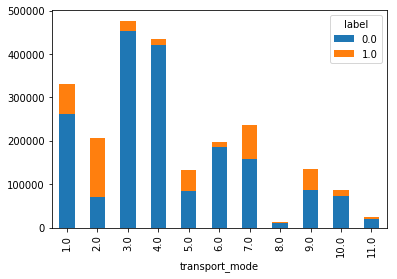

In [286]:
hourDF = train.groupby(['transport_mode', 'label'])['transport_mode'].count().unstack('label').fillna(0)
hourDF[[0,1]].plot(kind='bar', stacked=True)

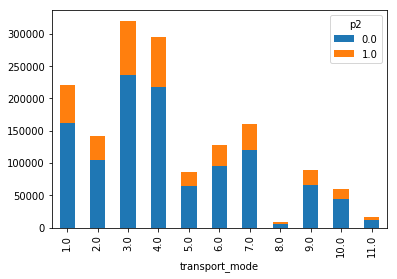

In [413]:
hourDF = train.groupby(['transport_mode', 'p2'])['transport_mode'].count().unstack('p2').fillna(0)
hourDF[[0,1]].plot(kind='bar', stacked=True)

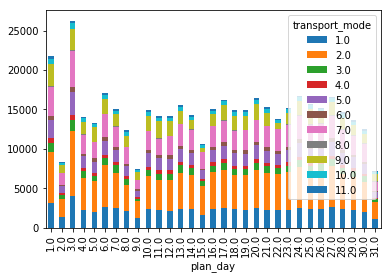

In [460]:
tmp = train[train['label']==1]
dayDF = tmp.groupby(['plan_day','transport_mode'])['plan_day'].count().unstack('transport_mode').fillna(0)
dayDF.plot(kind='bar', stacked=True)

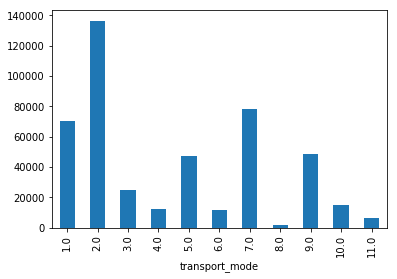

In [463]:
tmp.groupby(['transport_mode'])['transport_mode'].count().plot(kind='bar')

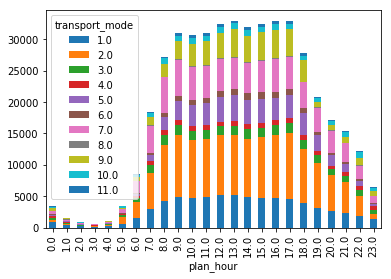

In [461]:
dayDF = tmp.groupby(['plan_hour','transport_mode'])['plan_hour'].count().unstack('transport_mode').fillna(0)
dayDF.plot(kind='bar', stacked=True)

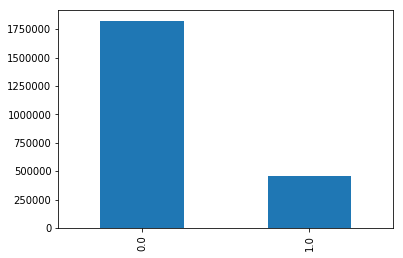

In [288]:
train['label'].value_counts().plot(kind='bar')

In [283]:
train.groupby(['transport_mode', 'label'])['transport_mode'].count().unstack('label')
train.groupby(['transport_mode', 'label'])['transport_mode'].count()

transport_mode  label
1.0             0.0      261426
                1.0       70369
2.0             0.0       70528
                1.0      136491
3.0             0.0      452492
                1.0       24626
4.0             0.0      420962
                1.0       12606
5.0             0.0       85332
                1.0       47480
6.0             0.0      184739
                1.0       11863
7.0             0.0      159100
                1.0       78209
8.0             0.0       10473
                1.0        1857
9.0             0.0       86659
                1.0       48864
10.0            0.0       72983
                1.0       14882
11.0            0.0       18792
                1.0        6089
Name: transport_mode, dtype: int64

In [290]:
train['price'].value_counts()

         814355
500      167512
200      151633
400      148350
600      111474
700       96135
300       77730
800       49488
1300      48557
900       34252
1800      24406
1700      20821
1000      17529
1900      16280
2000      14246
3000      12542
2900      11565
2100      11433
1100      11360
1500      11294
2200      11240
1400      10962
3200      10514
2700      10449
2500      10442
1600      10240
3100      10176
2300      10098
2800       9904
2400       9486
          ...  
37500         1
39700         1
41600         1
43100         1
43800         1
44500         1
46200         1
46800         1
47500         1
47600         1
47900         1
48000         1
48300         1
48700         1
48800         1
48900         1
49900         1
50100         1
50200         1
50300         1
50600         1
50800         1
51000         1
51100         1
51200         1
51300         1
51600         1
52300         1
52500         1
92300         1
Name: price, Length: 541

In [277]:
train[train['transport_mode']==5][['o','d','distance','eta','price','transport_mode']]
train[train['transport_mode']==5]['price'].values

array(['', '', '', ..., '', '', ''], dtype=object)

In [256]:
click[click['sid']==508311]

,sid,click_time,click_mode


In [148]:
train[['o','d','distance','eta','price','transport_mode','click_mode']]

,o,d,distance,eta,price,transport_mode,click_mode
0,"116.29,39.97","116.32,39.96",5219.0,1367.0,300,9.0,9.0
1,"116.29,39.97","116.32,39.96",4537.0,1035.0,,3.0,9.0
2,"116.29,39.97","116.32,39.96",4537.0,1095.0,2100,4.0,9.0
3,"116.29,39.97","116.32,39.96",4118.0,1243.0,,6.0,9.0
4,"116.29,39.97","116.32,39.96",5219.0,1679.0,300,2.0,9.0
5,"116.29,39.97","116.32,39.96",4046.0,3672.0,,5.0,9.0
6,"116.39,39.84","116.33,39.79",13864.0,3221.0,600,7.0,1.0
7,"116.39,39.84","116.33,39.79",11106.0,1122.0,,3.0,1.0
8,"116.39,39.84","116.33,39.79",11106.0,1362.0,2900,4.0,1.0
9,"116.39,39.84","116.33,39.79",13488.0,2315.0,400,9.0,1.0


In [235]:
tmp = train[train['label']==1]
tmp.shape

(453336, 84)

In [155]:
tmp.groupby('sid').count()

,pid,req_time,o,d,plan_time,plan_day,plan_hour,plan_num,plan_order,distance,...,p59,p60,p61,p62,p63,p64,p65,click_time,click_mode,label
sid,,,,,,,,,,,,,,,,,,,,,
10,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
21,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
25,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
34,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1
35,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
36,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
44,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
68,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1
69,0,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,2,2,2


In [164]:
df_plan.drop_duplicates().shape

(2706625, 10)

In [166]:
df_plan['transport_mode'].value_counts()

3     567019
4     515934
1     393982
7     281512
2     246624
6     234134
9     160854
5     158316
10    103237
11     29345
8      15668
Name: transport_mode, dtype: int64

In [169]:
click['click_mode'].value_counts()

2     136491
7      78209
1      70369
9      48864
5      47480
3      24626
10     14882
4      12606
6      11863
11      6089
8       1857
Name: click_mode, dtype: int64

In [182]:
train[(train['plan_order']==1) & (train['label']==1)].shape

(331782, 83)

In [173]:
plans[['plan_time','plan_weekday']]

,plan_time,plan_weekday
0,2018-11-04 11:45:04,6
1,2018-10-16 19:09:29,1
2,2018-11-25 15:05:22,6
3,2018-10-03 14:42:40,2
4,2018-10-05 19:52:37,4
5,2018-10-01 07:03:52,0
6,2018-10-22 11:45:20,0
7,2018-11-13 18:51:27,1
8,2018-11-26 12:43:56,0
9,2018-11-23 19:34:38,4


In [195]:
for sid ,data in train.groupby(['sid']):
    print(sid)
    print(data)
    break

2
        sid  pid             req_time             o             d  \
129957    2  NaN  2018-11-10 12:47:12  116.39,39.92  116.41,39.91   
129958    2  NaN  2018-11-10 12:47:12  116.39,39.92  116.41,39.91   
129959    2  NaN  2018-11-10 12:47:12  116.39,39.92  116.41,39.91   
129960    2  NaN  2018-11-10 12:47:12  116.39,39.92  116.41,39.91   
129961    2  NaN  2018-11-10 12:47:12  116.39,39.92  116.41,39.91   
129962    2  NaN  2018-11-10 12:47:12  116.39,39.92  116.41,39.91   

                 plan_time  plan_day  plan_hour  plan_weekday  plan_num  ...  \
129957 2018-11-10 12:47:12      10.0       12.0           6.0       6.0  ...   
129958 2018-11-10 12:47:12      10.0       12.0           6.0       6.0  ...   
129959 2018-11-10 12:47:12      10.0       12.0           6.0       6.0  ...   
129960 2018-11-10 12:47:12      10.0       12.0           6.0       6.0  ...   
129961 2018-11-10 12:47:12      10.0       12.0           6.0       6.0  ...   
129962 2018-11-10 12:47:12      10

In [612]:
# lgb 参数
lgb_params = {
    "objective": "binary",
    "subsample": 0.9,
    "subsample_freq": 1,
    "boosting_type": "gbdt",
    "num_leaves": 120,
    "max_depth": -1,   
    "reg_alpha": 3,
    "learning_rate": 0.05,
    "random_state": 1000,
    "n_estimators": 15000,
    "n_jobs": 16,
    "colsample_bytree": 0.77,
    "min_child_weight": 4,
    "min_child_samples": 5, 
    "min_split_gain": 0.01
}
fold_num = 5
skf = StratifiedKFold(n_splits=fold_num, random_state=2019, shuffle=True)
f1_value = []

def f1_score_vail(pred, data_vail):
    y_true = data_vail.get_label()
    y_pred = np.round(pred)      # scikits f1 doesn't like probabilities
    score_vail = f1_score(y_true, y_pred, average='weighted')
    return 'f1', score_vail, True

#以sid，transport_mode比例划分训练测试集
evals_result = {} 
train_sub = train[train['label']==1][['sid','transport_mode']]
for index, (train_index, valid_index) in enumerate(skf.split(train_sub, train_sub['transport_mode'])):
    print("flod_num:%d" %index)  
    train_df = train[train['sid'].isin(train_sub.iloc[train_index,0].values)]
    valid_df = train[train['sid'].isin(train_sub.iloc[valid_index,0].values)]
    train_data = lgb.Dataset(train_df.iloc[:,:-1], label=train_df.iloc[:,-1])  # 训练数据
    valid_data = lgb.Dataset(valid_df.iloc[:,:-1], label=valid_df.iloc[:,-1])  # 验证数据
    lgb_model = lgb.train(lgb_params, train_data, num_boost_round=500, valid_sets =[valid_data],
                          early_stopping_rounds=100, feval=f1_score_vail, verbose_eval=20,
                          evals_result=evals_result) 
    #验证
    y_valid = lgb_model.predict(valid_df.iloc[:,:-1], num_iteration=lgb_model.best_iteration)
    y_valid = np.round(y_valid)
    f1_value.append(f1_score(valid_df.iloc[:,-1].values, y_valid, average='weighted'))  # 计算f1值
    #测试集
    y_test = lgb_model.predict(test, num_iteration=lgb_model.best_iteration)
    if index == 0:
        cv_pred = np.array(y_test).reshape(-1,1)
    else:
        cv_pred = np.hstack((cv_pred, np.array(y_test).reshape(-1,1)))  #np.vstack():在竖直方向上堆叠; np.hstack():在水平方向上平铺        
f1_value